# Background Subtraction Method

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import seaborn as sns
import os
import matplotlib.pyplot as plt

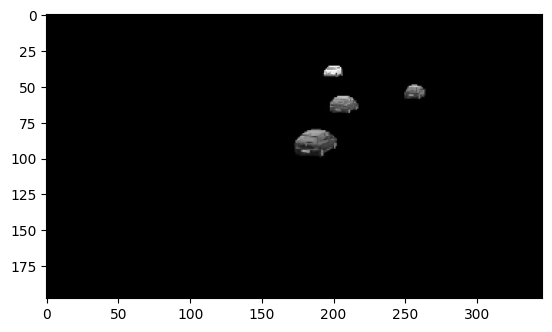

In [29]:
img_ground_truth = cv.imread('../experiments/img/09/00025_8880-5.jpg')
img_ground_truth = cv.cvtColor(img_ground_truth, cv.COLOR_BGR2GRAY)
img_ground_truth= cv.resize(img_ground_truth, (int(img_ground_truth.shape[1] * 0.4), int(img_ground_truth.shape[0] * 0.4)))
background_dir = '../dataset/frames/test/video25'

imgs = []

for filename in os.listdir(background_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(background_dir, filename)
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        imgs.append(img)

frames_stack = np.stack(imgs, axis=-1)

background_median = np.median(frames_stack, axis=-1).astype(np.uint8)
background_median = cv.resize(background_median, (int(background_median.shape[1] * 0.4), int(background_median.shape[0] * 0.4)))

plt.imshow(img_ground_truth, cmap='gray')

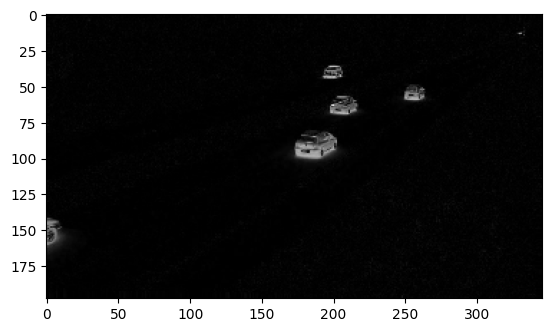

In [33]:
foreground_images = []

for filename in os.listdir(background_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(background_dir, filename)
        frame = cv.imread(img_path)
        frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        frame = cv.resize(frame, (int(frame.shape[1] * 0.4), int(frame.shape[0] * 0.4)))
        foreground = cv.absdiff(frame, background_median)
        foreground_images.append(foreground)

for i, foreground in enumerate(foreground_images):
    cv.imshow('Foreground Image {}'.format(i), foreground)
    cv.waitKey(0)

plt.imshow(foreground_images[11], cmap='gray')
cv.destroyAllWindows()

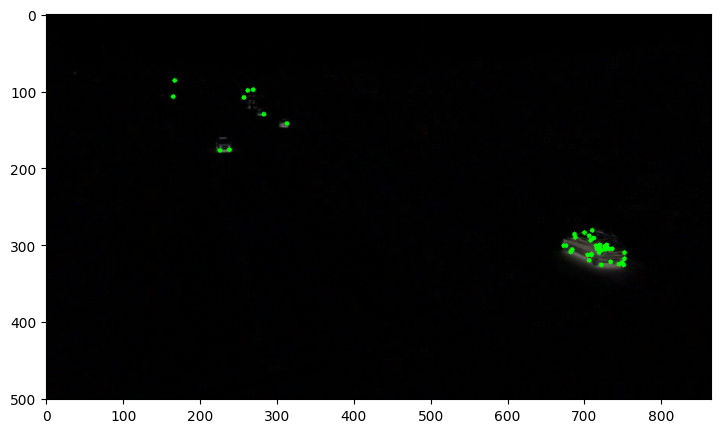

In [ ]:
# bf = cv.BFMatcher()
# orb = cv.SIFT_create()
# img = foreground_images[10]
# dir = '../experiments/img/09'

# img_ground_truths = []

# for filename in os.listdir(dir):
#     if filename.endswith('.jpg') or filename.endswith('.png'):
#         img_path = os.path.join(dir, filename)
#         img_ground_truth = cv.imread(img_path)
#         img_ground_truth = cv.cvtColor(img_ground_truth, cv.COLOR_BGR2RGB)
#         img_ground_truths.append(img_ground_truth)
        

# bf = cv.BFMatcher()
# orb = cv.SIFT_create()

# img = foreground_images[10]

# all_bbox_lists = []
# good_matches = []

# for img_ground_truth in img_ground_truths:
#     keypoints_frame, descriptors_frame = orb.detectAndCompute(img, None)
#     keypoints_grd, descriptors_grd = orb.detectAndCompute(img_ground_truth, None)

#     matches = bf.knnMatch(descriptors_grd, descriptors_frame, k=2)

#     for m, n in matches:
#         if m.distance < 1 * n.distance:
#             good_matches.append(m)
    
#     bbox_list = []
#     for match in good_matches:
#         frame_idx = match.trainIdx
#         frame_pt = keypoints_frame[frame_idx].pt
#         bbox = ((int(frame_pt[0] - 0), int(frame_pt[1] - 0)),
#                 (int(frame_pt[0] + 0), int(frame_pt[1] + 0))) 
#         bbox_list.append(bbox)
    
#     all_bbox_lists.append(bbox_list)

# merged_bbox_list = []
# for bbox_list in all_bbox_lists:
#     merged_bbox_list.extend(bbox_list)

# for bbox in merged_bbox_list:
#     cv.rectangle(img, bbox[0], bbox[1], (0, 255, 0), 5)

# plt.figure(figsize=(20, 5))
# plt.imshow(img)
# plt.show()


# feature detection on resized image

accuracy: 108.23%
Confusion Matrix:
True Positives (TP): 171
False Positives (FP): 0
True Negatives (TN): -13
False Negatives (FN): 0
All Truth Keypoints 171
All Estimated Keypoints 158


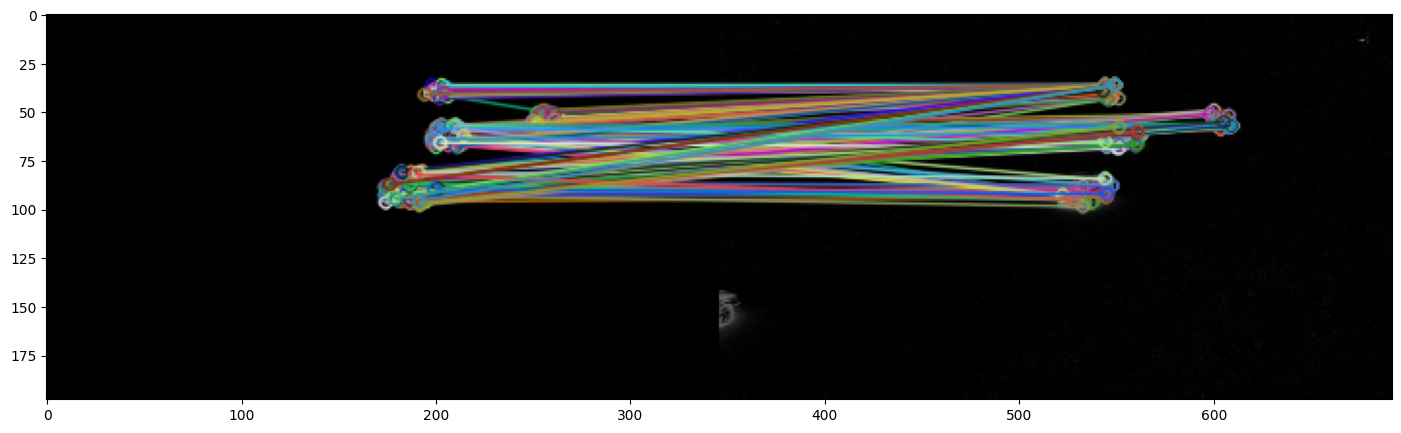

In [70]:
bf = cv.BFMatcher()
orb = cv.ORB_create()
img_subtracted = foreground_images[11]

keypoints_img_ground_truth, descriptors_img_ground_truth = orb.detectAndCompute(img_ground_truth, None)
keypoints_img_subtracted, descriptors_img_subtracted = orb.detectAndCompute(img_subtracted, None)

matches = bf.knnMatch(descriptors_img_ground_truth, descriptors_img_subtracted, k=2)

good_matches = []
total_correct = 0
TP = FP = TN = FN = 0
for m, n in matches:
    if m.distance < 1 * n.distance:
        good_matches.append(m)
        total_correct += 1
        TP += 1 
    else:
        FP += 1

img_matches = cv.drawMatches(img_ground_truth, keypoints_img_ground_truth, img_subtracted, keypoints_img_subtracted, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

ground_truth_keypoints = total_correct
predicted_keypoints = len(keypoints_img_subtracted)

FN = len(keypoints_img_ground_truth) - TP
TN = len(keypoints_img_subtracted) - TP - FP - FN

print(f"accuracy: {ground_truth_keypoints / predicted_keypoints :.2%}")
print("Confusion Matrix:")
print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("True Negatives (TN):", TN)
print("False Negatives (FN):", FN)
print("All Truth Keypoints", len(keypoints_img_ground_truth))
print("All Estimated Keypoints", len(keypoints_img_subtracted))
plt.figure(figsize=(20,5))
plt.imshow(img_matches)

# feature detection on resized & shadow detection image

In [66]:
import cv2 as cv
import numpy as np

def shadow_detection(image_gray):
    image_rgb = cv.cvtColor(image_gray, cv.COLOR_GRAY2RGB)
    lab_image = cv.cvtColor(image_rgb, cv.COLOR_RGB2LAB)

    mean_l = np.mean(lab_image[:, :])
    std_l = np.std(lab_image[:, :])

    shadow_mask = lab_image[:, :] <= (mean_l - std_l/3)

    kernel = np.ones((3, 3), np.uint8)
    cleaned_mask = cv.morphologyEx(shadow_mask.astype(np.uint8), cv.MORPH_OPEN, kernel)
    shadow_mask_cleaned = cv.dilate(cleaned_mask, kernel, iterations=1)
    shadow_mask_cleaned = cv.erode(shadow_mask_cleaned, kernel, iterations=1)

    result_image = np.copy(image_gray)
    result_image[shadow_mask_cleaned] = [0]

    return result_image, shadow_mask_cleaned

def shadow_remove(image_gray, shadow_mask):
    image_float = image_gray.astype(np.float32)

    shadow_pixels = np.where(shadow_mask)
    avg_intensity_inside_shadow = np.mean(image_float[shadow_pixels[0], shadow_pixels[1]])
    outside_shadow_mask = ~shadow_mask
    outside_shadow_pixels = np.where(outside_shadow_mask)
    avg_intensity_outside_shadow = np.mean(image_float[outside_shadow_pixels[0], outside_shadow_pixels[1]])

    constants = avg_intensity_outside_shadow / avg_intensity_inside_shadow

    image_float[shadow_pixels[0], shadow_pixels[1]] *= constants

    result_image = np.clip(image_float, 0, 255).astype(np.uint8)

    return result_image

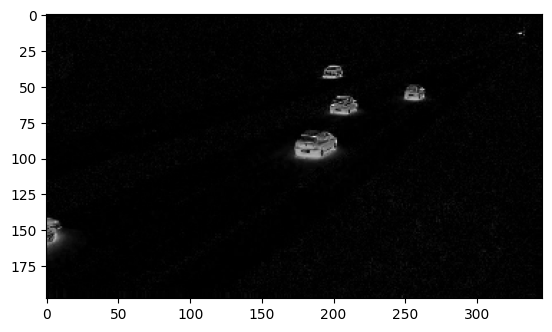

In [67]:
img_subtracted = foreground_images[11]
result_shadow_img, shadow_mask = shadow_detection(img_subtracted)
img_subtracted_shadow_detected = shadow_remove(result_shadow_img,shadow_mask)

plt.imshow(img_subtracted_shadow_detected, cmap='gray')

accuracy: 96.07%
Confusion Matrix:
True Positives (TP): 171
False Positives (FP): 0
True Negatives (TN): 7
False Negatives (FN): 0
All Truth Keypoints 171
All Estimated Keypoints 178


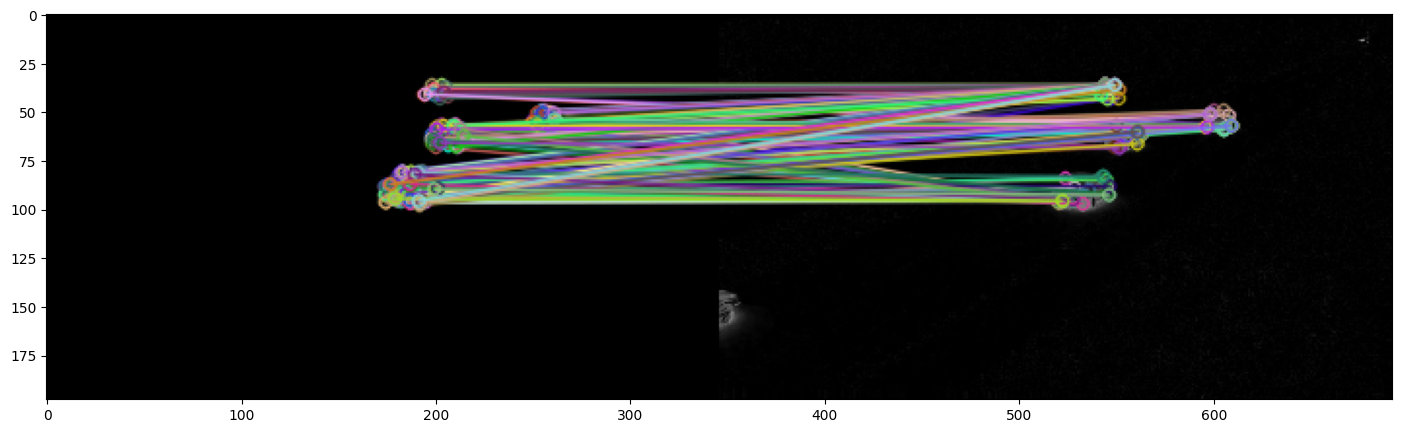

In [71]:
# feature detection
orb = cv.ORB_create()

keypoints_img_ground_truth, descriptors_img_ground_truth = orb.detectAndCompute(img_ground_truth, None)
keypoints_img_subtracted_shadow_detected, descriptors_img_subtracted_shadow_detected = orb.detectAndCompute(img_subtracted_shadow_detected, None)

# object matching
bf = cv.BFMatcher()

matches = bf.knnMatch(descriptors_img_ground_truth, descriptors_img_subtracted_shadow_detected, k=2)

good_matches = []
total_correct = 0
TP = FP = TN = FN = 0
for m, n in matches:
    if m.distance < 1 * n.distance:
        good_matches.append(m)
        total_correct += 1
        TP += 1 
    else:
        FP += 1

img_matches = cv.drawMatches(img_ground_truth, keypoints_img_ground_truth, img_subtracted_shadow_detected, keypoints_img_subtracted_shadow_detected, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

ground_truth_keypoints = total_correct
predicted_keypoints = len(keypoints_img_subtracted_shadow_detected)

TN = len(keypoints_img_subtracted_shadow_detected) - (TP + FP)
FN = len(keypoints_img_subtracted_shadow_detected) - TP - FP - TN

print(f"accuracy: {ground_truth_keypoints / predicted_keypoints :.2%}")
print("Confusion Matrix:")
print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("True Negatives (TN):", TN)
print("False Negatives (FN):", FN)
print("All Truth Keypoints", len(keypoints_img_ground_truth))
print("All Estimated Keypoints", len(keypoints_img_subtracted_shadow_detected))
plt.figure(figsize=(20,5))
plt.imshow(img_matches)